# Effective Dimension of Qiskit Neural Networks

In this tutorial, we will take advantage of the `EffectiveDimension` and `LocalEffectiveDimension` classes to evaluate the power of Quantum Neural Network models. These are metrics based on information geometry that connect to notions such as trainability, expressibility or ability to generalize.

Before diving into the code example, we will briefly explain what is the difference between these two metrics, and why are they relevant to the study of Quantum Neural Networks. More information about global effective dimension can be found in ['this paper'](https://arxiv.org/pdf/2011.00027.pdf), while the local effective dimension was introduced in a ['later work'](https://arxiv.org/abs/2112.04807), both by Abbas et al.

## 1. Global vs. Local Effective Dimension

Both classical and quantum machine learning models share a common goal: being good at **generalizing**, i.e. learning from data and applying these learnings on unseen data. Finding a good metric to assess this ability is a non-trivial matter. In [The Power of Quantum Neural Networks](https://arxiv.org/pdf/2011.00027.pdf), Abbas et al. introduce the **Global** Effective Dimension as a useful indicator of how well a particular model will be able to perform on new data.

Both the Global and Local Effective Dimension algorithms use the Fisher Information matrix to provide a measure of complexity. The details on how this matrix is calculated are provided in the [reference paper](https://arxiv.org/pdf/2011.00027.pdf), but in general terms, this matrix captures how sensitive a neural network's output is to changes in the network's parameter space.

The key difference between Global and Local Effective Dimension is actually not on the way they are computed, but in the nature of the parameter space that is analyzed. The global effective dimension incorporates the **full parameter space** of the model, and is calculated from a **large number of parameters sets**. On the other hand, the local effective dimension focuses on how well the **trained** model can generalize to new data, and thus only requires **1** set of parameters values (training result) for its calculation.

## 2. Basic Example (CircuitQNN)

This example shows how to set up a QNN model problem and run the global effective dimension algorithm.



In [1]:
# Necessary imports
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit.utils import QuantumInstance
from qiskit import Aer, QuantumCircuit

In [3]:
from qiskit_machine_learning.algorithms.effective_dimension import EffectiveDimension, LocalEffectiveDimension

In [4]:
# declare quantum instance
qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

This example will show how to use the `EffectiveDimension` class with a `CircuitQNN`, but `OpflowQNN`s can also be provided to this class.

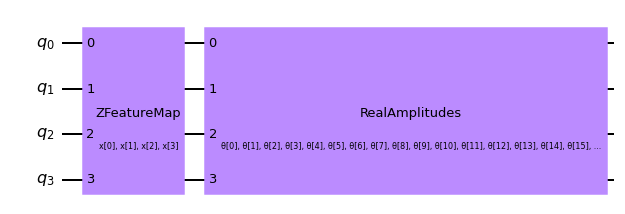

In [5]:
num_qubits = 4
# create a feature map
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
# create a variational circuit
ansatz = RealAmplitudes(num_qubits, reps=9)

# create quantum circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))
qc.decompose().draw( 'mpl')

In [6]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [7]:
# construct QNN
qnn = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
    quantum_instance=qi_sv
)

### 2. Define the Problem

In order to define the problem, we need a series of sets of inputs and parameters, as well as the total number of data (n). The `inputs` and `params` are set in the class constructor, while the number of data is given during the call to the effective dimension computation to be able to test and compare how this measure changes with different dataset sizes.

In [8]:
# we can set a callback to see how long each QNN pass takes
def callback(msg):
    print(msg)

In [9]:
# we can provide user-defined inputs and parameters
inputs = np.random.normal(0, 1, size=(10, qnn.num_inputs))
params = np.random.uniform(0, 1, size=(10, qnn.num_weights))

global_ed = EffectiveDimension(qnn=qnn,
                               params= params,
                               inputs = inputs,
                               callback=callback)

In [10]:
# but we can also set the total number of input and parameter sets and these will be randomly selected for us:
num_inputs = 10
num_params = 10

global_ed = EffectiveDimension(qnn=qnn,
                               num_params=num_params,
                               num_inputs=num_inputs,
                               callback=callback)

In [11]:
# finally, we will define ranges to test different numbers of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

### 3. Compute the Global Effective Dimension

By calling the effective dimension class with an array if input sizes "n", we can get a series of effective dimension values that will range between 0 and `d`, where `d` represents the dimensionality of the model, and it's practically obtained from the number of weights of the QNN. By dividing the result by `d`, we can obtain the normalized effective dimension, which correlates with the capacity of the model.

In [12]:
d = global_ed.num_weights()
print(d)

40


In [13]:
global_eff_dim= global_ed.get_effective_dimension(n = n)
d = global_ed.num_weights()

iteration 0, time forward pass: 0.10596823692321777
iteration 0, time backward pass: 10.457154035568237
iteration 1, time forward pass: 0.04880404472351074
iteration 1, time backward pass: 5.400159120559692
iteration 2, time forward pass: 0.027145862579345703
iteration 2, time backward pass: 6.366457223892212
iteration 3, time forward pass: 0.026961803436279297
iteration 3, time backward pass: 4.994707107543945
iteration 4, time forward pass: 0.026348114013671875
iteration 4, time backward pass: 4.608032941818237
iteration 5, time forward pass: 0.028261184692382812
iteration 5, time backward pass: 4.450346946716309
iteration 6, time forward pass: 0.029237985610961914
iteration 6, time backward pass: 4.406252145767212
iteration 7, time forward pass: 0.0269010066986084
iteration 7, time backward pass: 4.7517688274383545
iteration 8, time forward pass: 0.02792811393737793
iteration 8, time backward pass: 5.167931795120239
iteration 9, time forward pass: 0.04049181938171387
iteration 9, ti

In [14]:
print("effdim: ", global_eff_dim)
print(d)

effdim:  [11.57191733 11.43125822 11.37318632 11.0981136  11.03749695 10.97001086
 10.92233926 10.89122772 10.80457749 10.74927134]
40


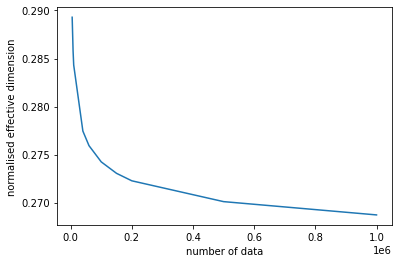

In [15]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(global_eff_dim)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

## 3. Local Effective Dimension Example

As explained in the introduction, the local effective dimension algorithm presents only one key difference from the global one, and that is the number of parameter sets accepted (1 set). The `LocalEffectiveDimension` class enforces this constraint to ensure that these calculations are conceptually separate.

In [16]:
local_ed = LocalEffectiveDimension(qnn=qnn,
                               params=params[0], # send only one set of parameters
                               inputs=inputs)

In [17]:
local_eff_dim, time = local_ed.get_effective_dimension(n = n)
d = local_ed.num_weights()
print(local_eff_dim)
# plot the normalised effective dimension for the model
plt.plot(n, np.array(local_eff_dim)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

ValueError: too many values to unpack (expected 2)